In [2]:
import numpy as np
import pandas as pd
import cv2
import keras
from numpy import random
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.applications import MobileNet, VGG16, ResNet50,DenseNet201,InceptionV3,EfficientNetB7
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report ,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import seaborn as sns
import os

In [3]:
train_folder = "Data/train"
valid_folder = "Data/valid"
test_folder = "Data/test"

In [4]:
print("\n\n\t\tTraining Set")
print("\t  ========================\n")
train_c = []
for folder in os.listdir(train_folder):
    train_c.append(folder)
    print("\nTrain "+ folder + " Class: ", len(os.listdir(train_folder + '/' + folder)))

print("\n\n", train_c)

print("\n\n\t\tTesting Set")
print("\t  ========================\n")
test_c = []
for folder in os.listdir(test_folder):
    test_c.append(folder)
    print("\nTest "+ folder + " Class: ", len(os.listdir(test_folder + '/' + folder)))

print("\n\n", test_c)

print("\n\n\t\tValidation Set")
print("\t  ========================\n")
val_c = []
for folder in os.listdir(valid_folder):
    val_c.append(folder)
    print("\nValidation "+ folder + " Class: ", len(os.listdir(valid_folder + '/' + folder)))

print("\n\n", val_c, "\n")



		Training Set


Train adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Class:  195

Train large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Class:  115

Train normal Class:  148

Train squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Class:  155


 ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


		Testing Set


Test adenocarcinoma Class:  120

Test large.cell.carcinoma Class:  51

Test normal Class:  54

Test squamous.cell.carcinoma Class:  90


 ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


		Validation Set


Validation adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Class:  23

Validation large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Class:  21

Validation normal Class:  13

Validation squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Class:  15


 ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal'

In [5]:
input_shape = (224,224,3)
num_class = 4

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle = False,
)
validation_generator = val_datagen.flow_from_directory(
    valid_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [6]:
modelVGG16 = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

for layer in modelVGG16.layers:
    layer.trainable = False

In [7]:
model = Sequential([
    modelVGG16,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])


print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 512)         0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4

In [8]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
opt1 = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

In [9]:
checkpoint = ModelCheckpoint(filepath = 'C_CT_S.h5',
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True,
                            verbose = 1)

earlystop = EarlyStopping(monitor = 'val_accuracy',
                         min_delta = .5,
                         patience = 5,
                         restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                             factor = 0.1,
                             patience = 3,
                             verbose = 1,
                             min_delta = 0.8)

callbacks = [earlystop, reduce_lr]

In [10]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)
test = test_generator
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/50
20/20 [==============================] - 109s 5s/step - loss: 2.3185 - accuracy: 0.4274 - val_loss: 2.2780 - val_accuracy: 0.4583
Epoch 2/50
20/20 [==============================] - 103s 5s/step - loss: 1.4684 - accuracy: 0.4747 - val_loss: 1.0762 - val_accuracy: 0.5000
Epoch 3/50
20/20 [==============================] - 103s 5s/step - loss: 1.0309 - accuracy: 0.5351 - val_loss: 1.0271 - val_accuracy: 0.5139
Epoch 4/50
20/20 [==============================] - 103s 5s/step - loss: 0.8521 - accuracy: 0.6281 - val_loss: 0.9427 - val_accuracy: 0.5417
Epoch 5/50
20/20 [==============================] - 102s 5s/step - loss: 0.8743 - accuracy: 0.6232 - val_loss: 1.0114 - val_accuracy: 0.5417
Epoch 6/50
20/20 [==============================] - 103s 5s/step - loss: 0.8045 - accuracy: 0.6427 - val_loss: 0.6056 - val_accuracy: 0.7500
Epoch 7/50
20/20 [==============================] - 102s 5s/step - loss: 0.6819 - accuracy: 0.7178 - val_loss: 0.5597 - val_accuracy: 0.7917
Epoch 8/50
20

In [11]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)

10/10 [==============================] - 43s 4s/step
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       120
           1       0.87      0.92      0.90        51
           2       1.00      0.94      0.97        54
           3       0.85      0.93      0.89        90

    accuracy                           0.91       315
   macro avg       0.92      0.92      0.92       315
weighted avg       0.92      0.91      0.91       315





Confusion Matrix:
 [[105   5   0  10]
 [  0  47   0   4]
 [  1   1  51   1]
 [  5   1   0  84]]


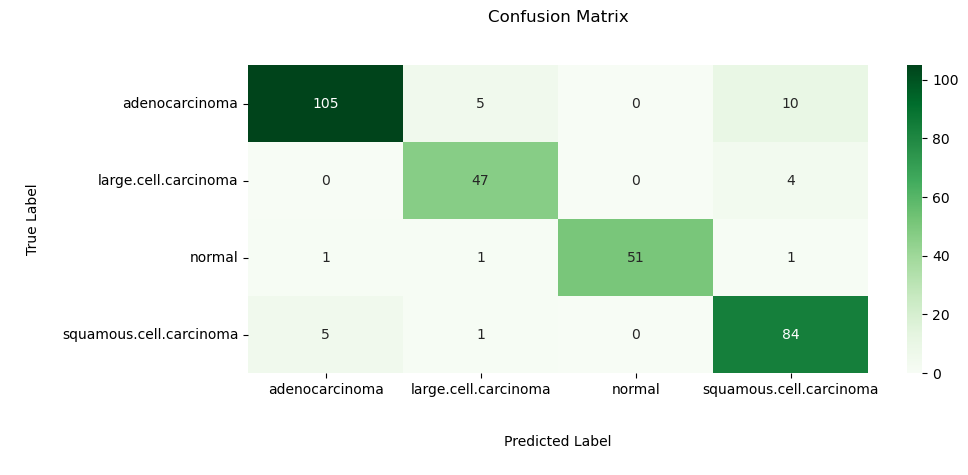

In [12]:
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = test_c, yticklabels = test_c)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

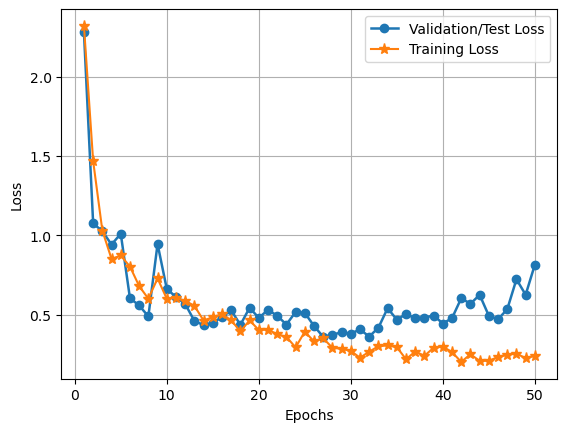

In [13]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

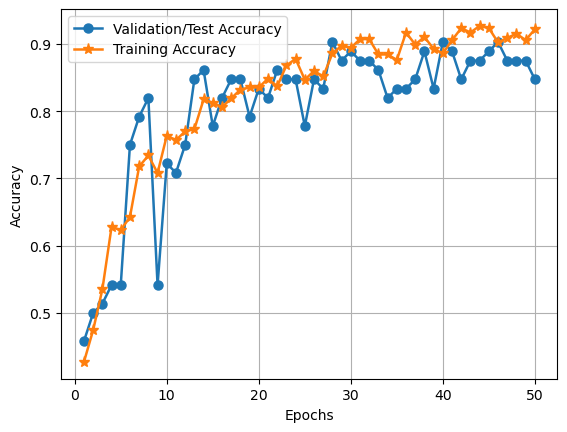

In [14]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

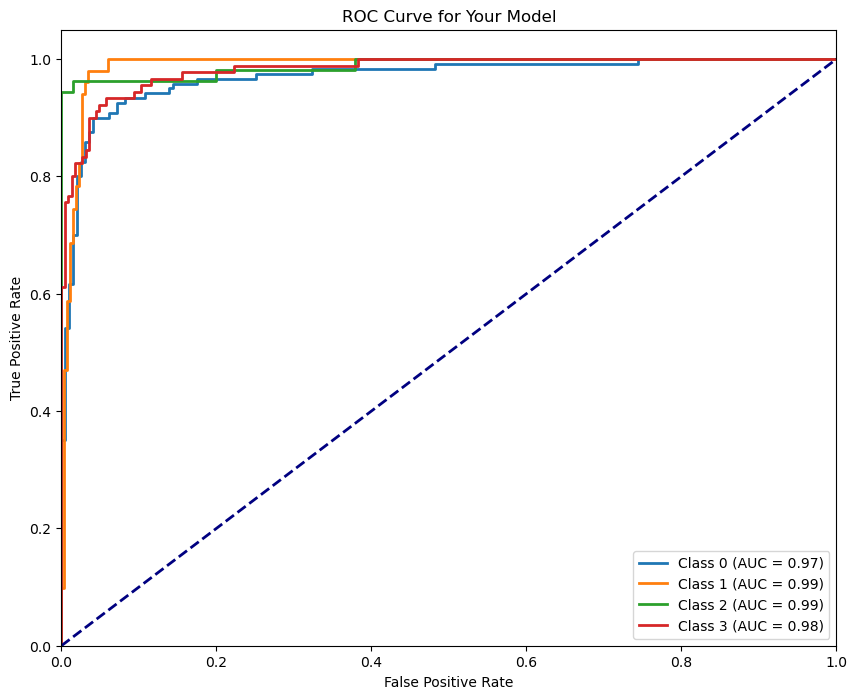

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(test_generator.class_indices)

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_probabilities[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Your Model')
plt.legend(loc="lower right")
plt.show()

In [16]:
ResNet50_model = ResNet50(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

for layer in ResNet50_model.layers:
    layer.trainable = False

In [17]:
model = Sequential([
    ResNet50_model,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])


print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 2048)        8192      
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 2048)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 3, 3, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)             

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
opt1 = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

In [19]:
checkpoint = ModelCheckpoint(filepath = 'C_CT_S.h5',
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True,
                            verbose = 1)

earlystop = EarlyStopping(monitor = 'val_accuracy',
                         min_delta = .5,
                         patience = 5,
                         restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                             factor = 0.1,
                             patience = 3,
                             verbose = 1,
                             min_delta = 0.8)

callbacks = [earlystop, reduce_lr]

In [20]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)
test = test_generator
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/50
20/20 [==============================] - 77s 3s/step - loss: 4.5904 - accuracy: 0.4095 - val_loss: 2.4333 - val_accuracy: 0.5278
Epoch 2/50
20/20 [==============================] - 66s 3s/step - loss: 2.7530 - accuracy: 0.4796 - val_loss: 2.1467 - val_accuracy: 0.4306
Epoch 3/50
20/20 [==============================] - 66s 3s/step - loss: 1.8870 - accuracy: 0.5514 - val_loss: 1.6285 - val_accuracy: 0.3750
Epoch 4/50
20/20 [==============================] - 66s 3s/step - loss: 1.4861 - accuracy: 0.5481 - val_loss: 0.9321 - val_accuracy: 0.6111
Epoch 5/50
20/20 [==============================] - 66s 3s/step - loss: 1.1251 - accuracy: 0.5840 - val_loss: 1.0177 - val_accuracy: 0.5139
Epoch 6/50
20/20 [==============================] - 66s 3s/step - loss: 1.0897 - accuracy: 0.5791 - val_loss: 0.9006 - val_accuracy: 0.5556
Epoch 7/50
20/20 [==============================] - 66s 3s/step - loss: 0.8925 - accuracy: 0.6313 - val_loss: 0.7816 - val_accuracy: 0.6111
Epoch 8/50
20/20 [==

In [21]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)

10/10 [==============================] - 14s 1s/step
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       120
           1       0.57      0.92      0.70        51
           2       1.00      0.98      0.99        54
           3       0.82      0.72      0.77        90

    accuracy                           0.80       315
   macro avg       0.81      0.84      0.81       315
weighted avg       0.83      0.80      0.80       315





Confusion Matrix:
 [[87 19  0 14]
 [ 4 47  0  0]
 [ 0  1 53  0]
 [ 9 16  0 65]]


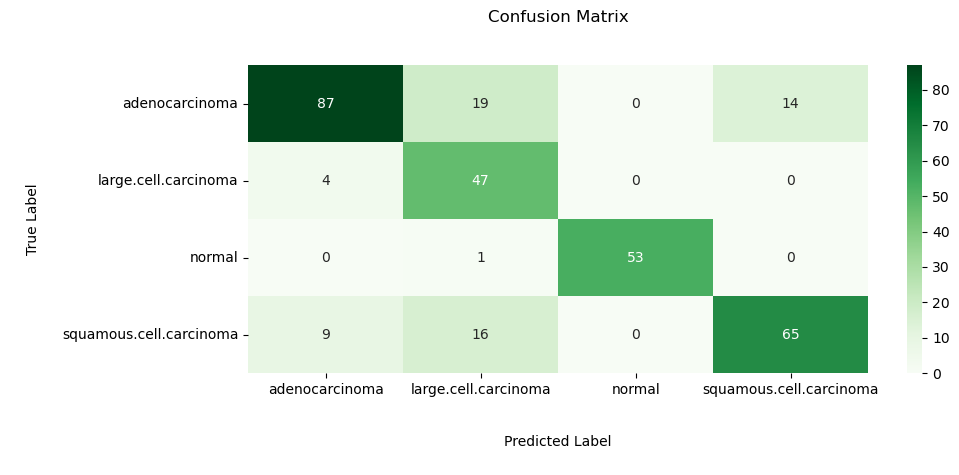

In [22]:
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = test_c, yticklabels = test_c)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

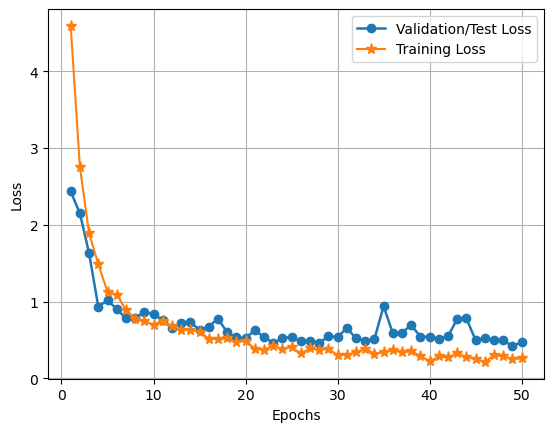

In [23]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

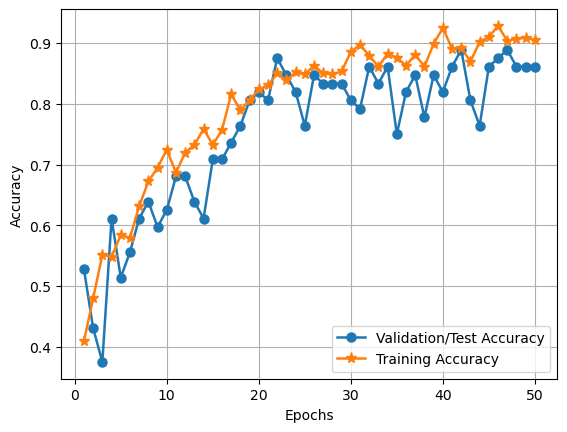

In [24]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

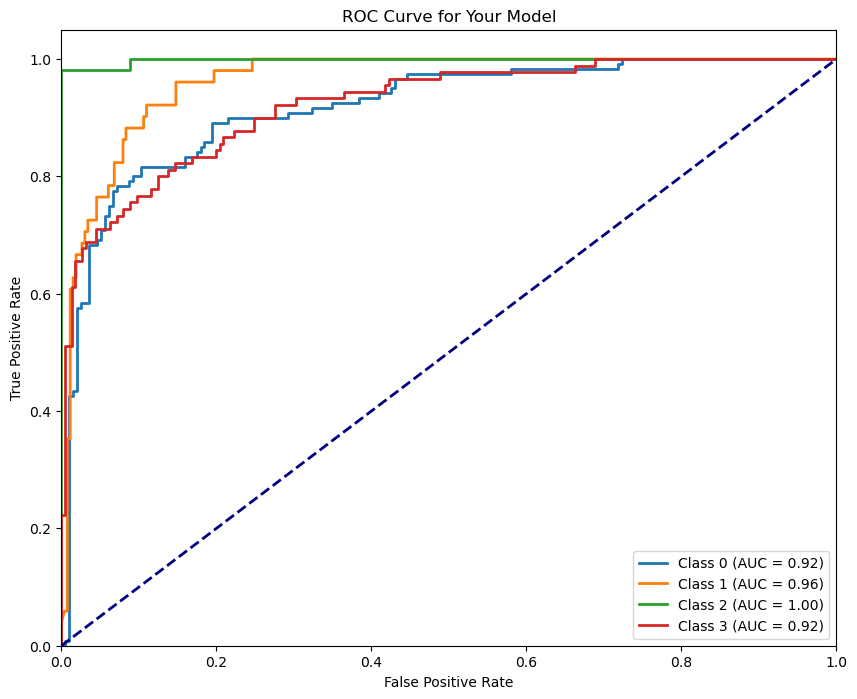

In [25]:
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(test_generator.class_indices)

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_probabilities[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Your Model')
plt.legend(loc="lower right")
plt.show()

In [26]:
DenseNet201_model = DenseNet201(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

for layer in DenseNet201_model.layers:
    layer.trainable = False

In [27]:
model = Sequential([
    DenseNet201_model,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
opt1 = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

In [29]:
checkpoint = ModelCheckpoint(filepath = 'C_CT_S.h5',
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True,
                            verbose = 1)

earlystop = EarlyStopping(monitor = 'val_accuracy',
                         min_delta = .5,
                         patience = 5,
                         restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                             factor = 0.1,
                             patience = 3,
                             verbose = 1,
                             min_delta = 0.8)

callbacks = [earlystop, reduce_lr]

In [30]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)
test = test_generator
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/50
20/20 [==============================] - 60s 3s/step - loss: 3.1854 - accuracy: 0.4405 - val_loss: 1.7520 - val_accuracy: 0.5139
Epoch 2/50
20/20 [==============================] - 53s 3s/step - loss: 2.0577 - accuracy: 0.5383 - val_loss: 2.2515 - val_accuracy: 0.2778
Epoch 3/50
20/20 [==============================] - 53s 3s/step - loss: 1.5835 - accuracy: 0.5106 - val_loss: 0.9907 - val_accuracy: 0.4722
Epoch 4/50
20/20 [==============================] - 52s 3s/step - loss: 1.3016 - accuracy: 0.5057 - val_loss: 0.9250 - val_accuracy: 0.5278
Epoch 5/50
20/20 [==============================] - 52s 3s/step - loss: 1.0901 - accuracy: 0.5661 - val_loss: 0.8905 - val_accuracy: 0.5417
Epoch 6/50
20/20 [==============================] - 52s 3s/step - loss: 1.0775 - accuracy: 0.5383 - val_loss: 0.8732 - val_accuracy: 0.5694
Epoch 7/50
20/20 [==============================] - 53s 3s/step - loss: 0.9352 - accuracy: 0.5840 - val_loss: 0.8941 - val_accuracy: 0.5278
Epoch 8/50
20/20 [==

In [31]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)

10/10 [==============================] - 24s 2s/step
              precision    recall  f1-score   support

           0       0.56      0.83      0.67       120
           1       0.61      0.73      0.66        51
           2       0.93      0.96      0.95        54
           3       0.75      0.17      0.27        90

    accuracy                           0.65       315
   macro avg       0.71      0.67      0.64       315
weighted avg       0.69      0.65      0.60       315





Confusion Matrix:
 [[100  13   2   5]
 [ 14  37   0   0]
 [  2   0  52   0]
 [ 62  11   2  15]]


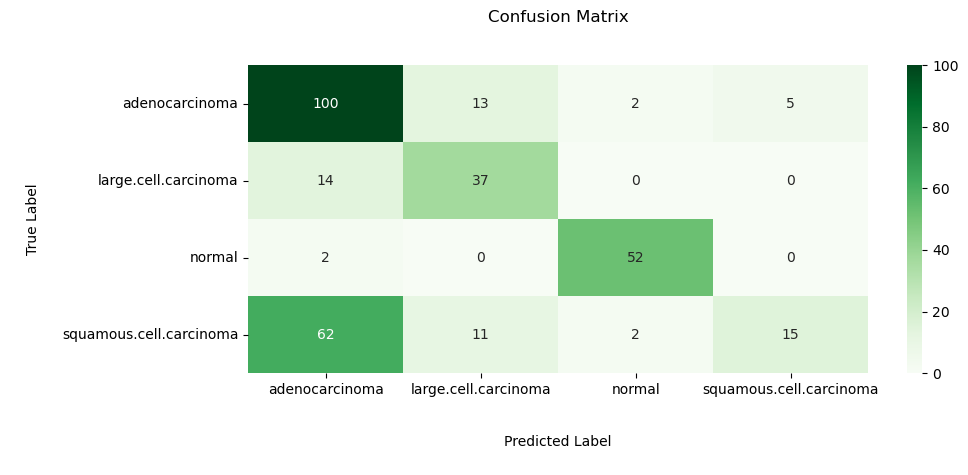

In [32]:
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = test_c, yticklabels = test_c)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

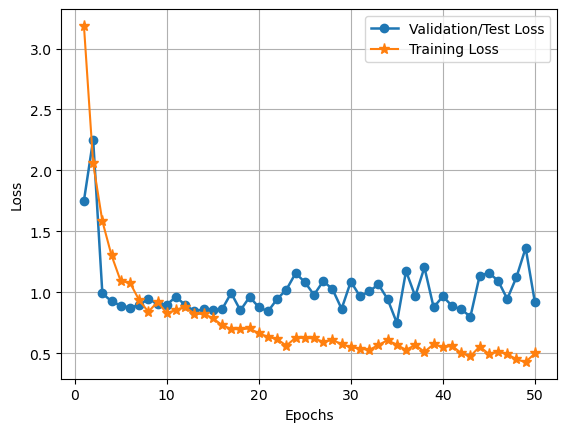

In [33]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

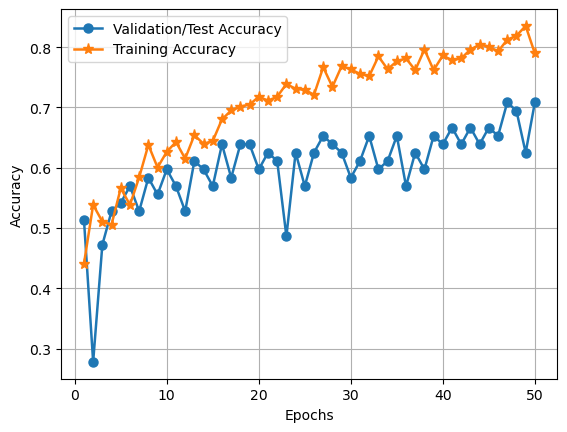

In [34]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

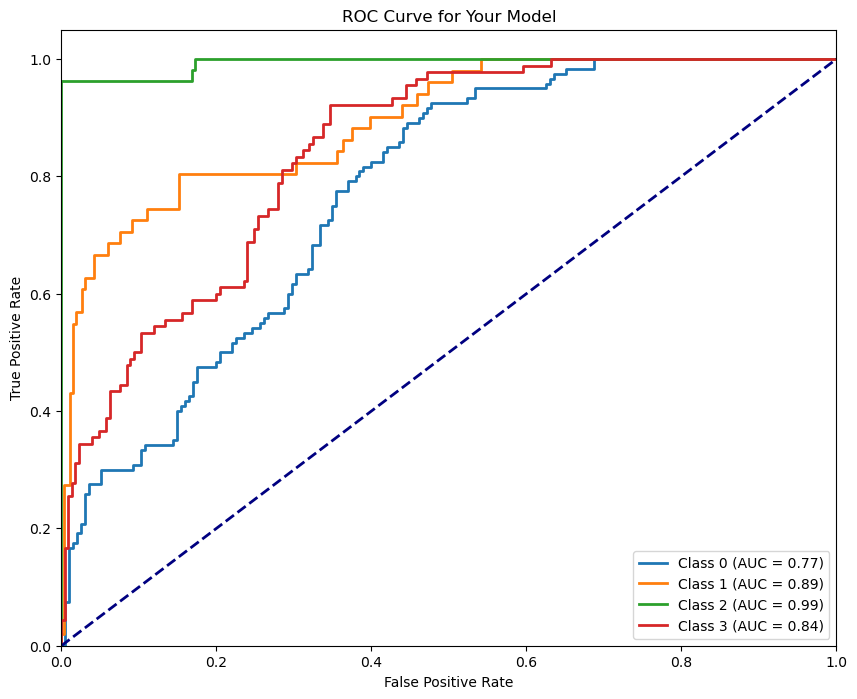

In [35]:
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(test_generator.class_indices)

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_probabilities[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Your Model')
plt.legend(loc="lower right")
plt.show()

In [36]:
InceptionV3_model = InceptionV3(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

for layer in InceptionV3_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 15s 0us/step


In [37]:
model = Sequential([
    InceptionV3_model,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 batch_normalization_97 (Ba  (None, 5, 5, 2048)        8192      
 tchNormalization)                                               
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 2, 2, 2048)        0         
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)             

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
opt1 = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

In [39]:
checkpoint = ModelCheckpoint(filepath = 'C_CT_S.h5',
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True,
                            verbose = 1)

earlystop = EarlyStopping(monitor = 'val_accuracy',
                         min_delta = .5,
                         patience = 5,
                         restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                             factor = 0.1,
                             patience = 3,
                             verbose = 1,
                             min_delta = 0.8)

callbacks = [earlystop, reduce_lr]

In [40]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)
test = test_generator
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/50
20/20 [==============================] - 21s 885ms/step - loss: 4.5135 - accuracy: 0.3556 - val_loss: 3.4458 - val_accuracy: 0.3611
Epoch 2/50
20/20 [==============================] - 19s 922ms/step - loss: 2.6169 - accuracy: 0.4029 - val_loss: 2.2013 - val_accuracy: 0.4861
Epoch 3/50
20/20 [==============================] - 19s 935ms/step - loss: 1.9364 - accuracy: 0.4192 - val_loss: 1.2079 - val_accuracy: 0.4722
Epoch 4/50
20/20 [==============================] - 19s 939ms/step - loss: 1.5269 - accuracy: 0.4502 - val_loss: 1.5496 - val_accuracy: 0.4722
Epoch 5/50
20/20 [==============================] - 19s 937ms/step - loss: 1.4249 - accuracy: 0.4829 - val_loss: 1.2326 - val_accuracy: 0.4722
Epoch 6/50
20/20 [==============================] - 19s 948ms/step - loss: 1.2943 - accuracy: 0.4747 - val_loss: 1.1755 - val_accuracy: 0.4861
Epoch 7/50
20/20 [==============================] - 19s 944ms/step - loss: 1.2185 - accuracy: 0.5155 - val_loss: 1.1713 - val_accuracy: 0.4444

In [41]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)

10/10 [==============================] - 8s 690ms/step
              precision    recall  f1-score   support

           0       0.56      0.90      0.69       120
           1       0.63      0.53      0.57        51
           2       0.98      0.98      0.98        54
           3       0.88      0.23      0.37        90

    accuracy                           0.66       315
   macro avg       0.76      0.66      0.65       315
weighted avg       0.73      0.66      0.63       315





Confusion Matrix:
 [[108  10   0   2]
 [ 22  27   1   1]
 [  1   0  53   0]
 [ 63   6   0  21]]


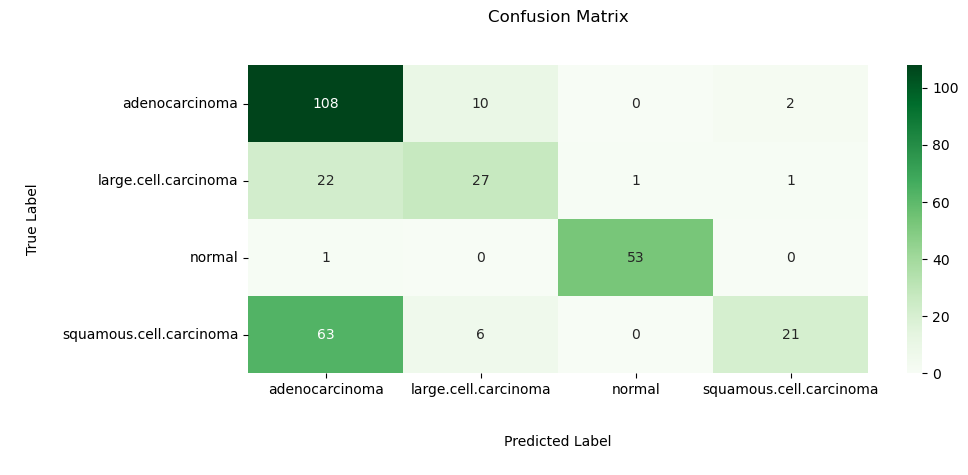

In [42]:
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = test_c, yticklabels = test_c)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

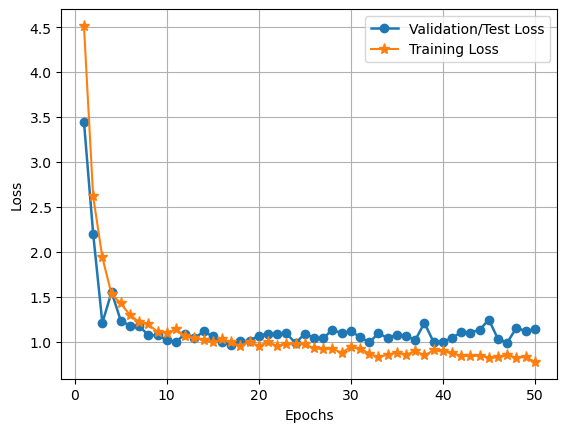

In [43]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

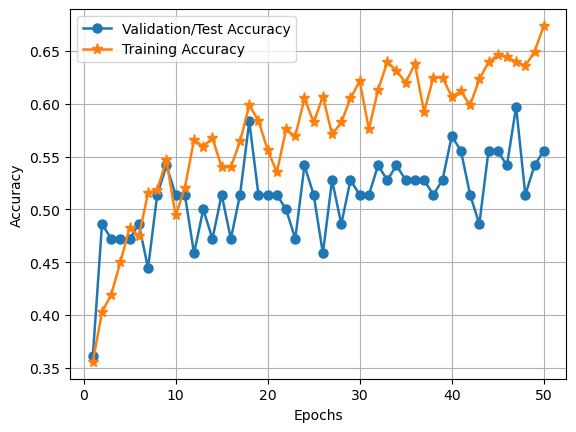

In [44]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

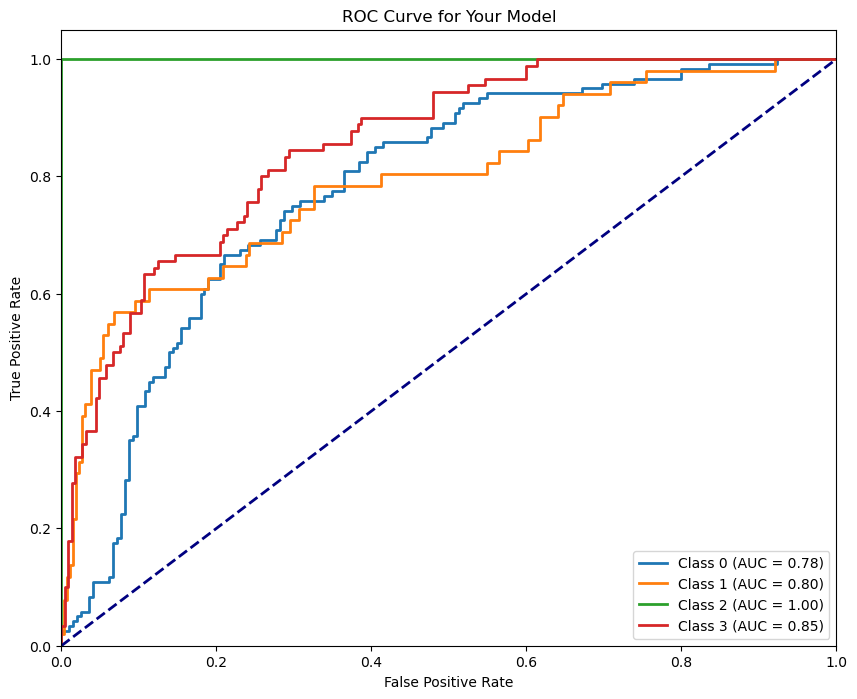

In [45]:
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(test_generator.class_indices)

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_probabilities[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Your Model')
plt.legend(loc="lower right")
plt.show()

In [46]:
EfficientNetB7_model = EfficientNetB7(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

for layer in EfficientNetB7_model.layers:
    layer.trainable = False

258076736/258076736 [==============================] - 34s 0us/step


In [47]:
model = Sequential([
    EfficientNetB7_model,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 7, 7, 2560)        64097687  
 )                                                               
                                                                 
 batch_normalization_98 (Ba  (None, 7, 7, 2560)        10240     
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 3, 3, 2560)        0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 3, 3, 2560)        0         
                                                                 
 flatten_4 (Flatten)         (None, 23040)             0         
                                                      

In [48]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
opt1 = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

In [49]:
checkpoint = ModelCheckpoint(filepath = 'C_CT_S.h5',
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True,
                            verbose = 1)

earlystop = EarlyStopping(monitor = 'val_accuracy',
                         min_delta = .5,
                         patience = 5,
                         restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                             factor = 0.1,
                             patience = 3,
                             verbose = 1,
                             min_delta = 0.8)

callbacks = [earlystop, reduce_lr]

In [50]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)
test = test_generator
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/50
20/20 [==============================] - 136s 6s/step - loss: 7.2181 - accuracy: 0.3100 - val_loss: 1.5003 - val_accuracy: 0.4028
Epoch 2/50
20/20 [==============================] - 114s 6s/step - loss: 4.0352 - accuracy: 0.3997 - val_loss: 1.2533 - val_accuracy: 0.4306
Epoch 3/50
20/20 [==============================] - 113s 6s/step - loss: 2.7238 - accuracy: 0.3997 - val_loss: 1.2350 - val_accuracy: 0.3889
Epoch 4/50
20/20 [==============================] - 113s 6s/step - loss: 1.9483 - accuracy: 0.4078 - val_loss: 1.1455 - val_accuracy: 0.4306
Epoch 5/50
20/20 [==============================] - 112s 6s/step - loss: 1.4829 - accuracy: 0.5008 - val_loss: 1.1007 - val_accuracy: 0.4444
Epoch 6/50
20/20 [==============================] - 112s 6s/step - loss: 1.3298 - accuracy: 0.4747 - val_loss: 1.0949 - val_accuracy: 0.4306
Epoch 7/50
20/20 [==============================] - 113s 6s/step - loss: 1.2210 - accuracy: 0.4927 - val_loss: 1.1075 - val_accuracy: 0.4444
Epoch 8/50
20

In [51]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)

10/10 [==============================] - 70s 7s/step
              precision    recall  f1-score   support

           0       0.56      0.91      0.69       120
           1       0.66      0.37      0.48        51
           2       0.95      0.98      0.96        54
           3       0.62      0.23      0.34        90

    accuracy                           0.64       315
   macro avg       0.69      0.62      0.62       315
weighted avg       0.66      0.64      0.60       315





Confusion Matrix:
 [[109   6   0   5]
 [ 23  19   1   8]
 [  1   0  53   0]
 [ 63   4   2  21]]


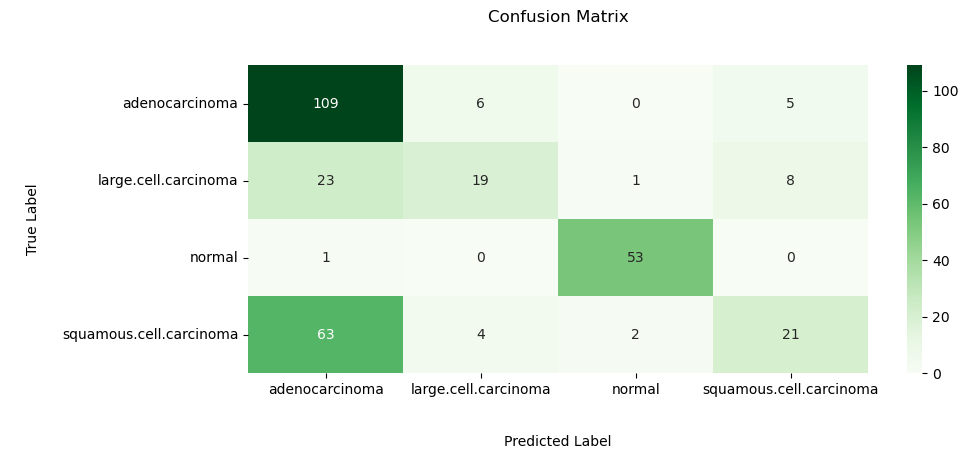

In [52]:
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = test_c, yticklabels = test_c)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

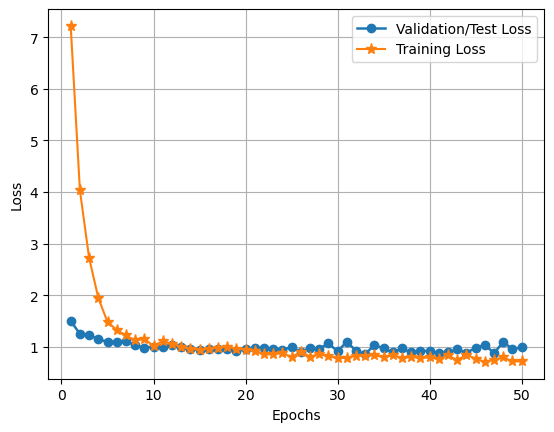

In [53]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

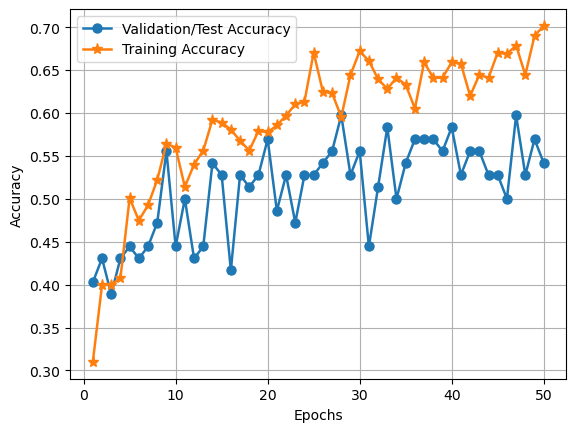

In [54]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

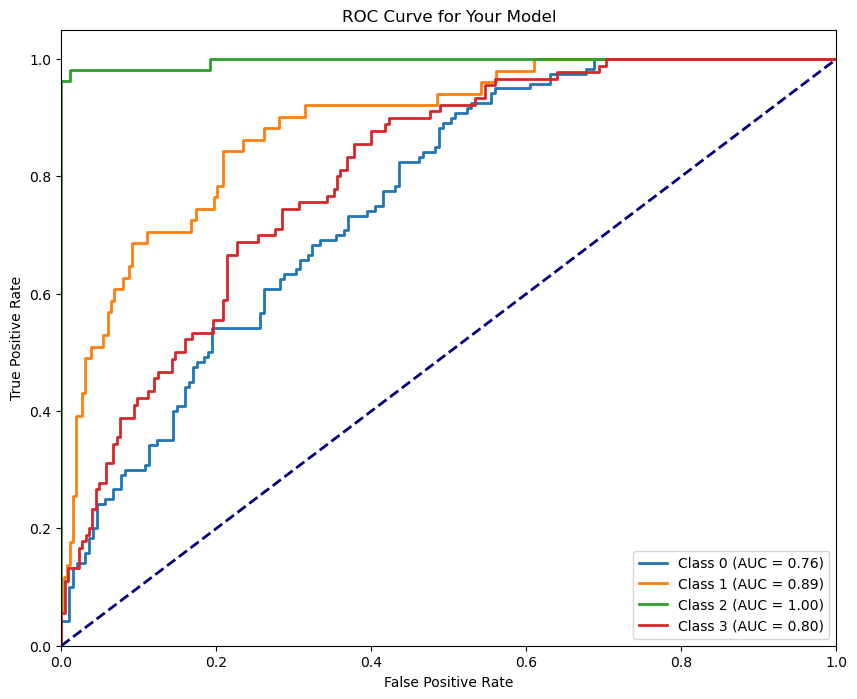

In [58]:
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(test_generator.class_indices)

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_probabilities[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Your Model') 
plt.legend(loc="lower right")
plt.show()

In [59]:
model_names = ['VGG16', 'ResNet50', 'DenseNet201', 'InceptionV3', 'EfficientNetB7']
precision = [0.73, 0.78, 0.69, 0.61, 0.54]
recall = [0.96, 0.81, 0.41, 0.74, 0.77]
f1_score = [0.83, 0.79, 0.51, 0.67, 0.63]
accuracy = [0.84, 0.79, 0.63, 0.69, 0.62]

data = {'Model': model_names, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score, 'Accuracy': accuracy}
df = pd.DataFrame(data)

print(df)

            Model  Precision  Recall  F1-Score  Accuracy
0           VGG16       0.73    0.96      0.83      0.84
1        ResNet50       0.78    0.81      0.79      0.79
2     DenseNet201       0.69    0.41      0.51      0.63
3     InceptionV3       0.61    0.74      0.67      0.69
4  EfficientNetB7       0.54    0.77      0.63      0.62


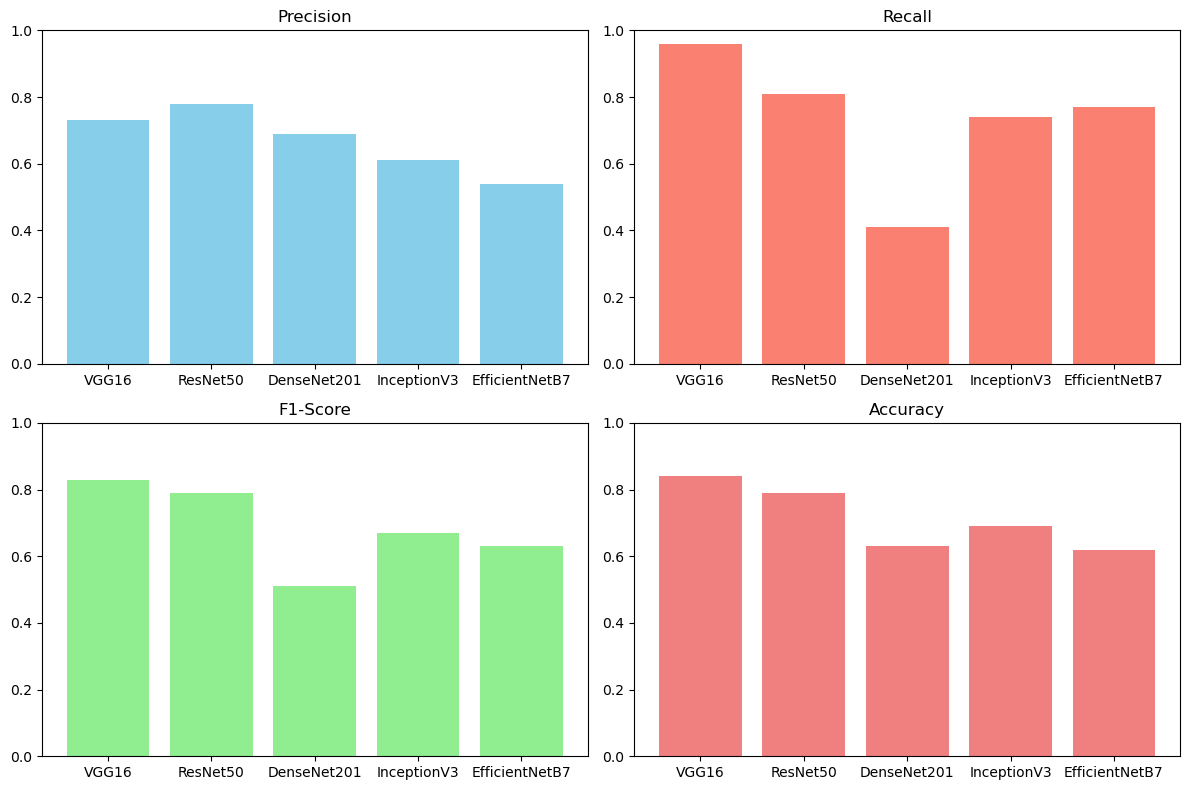

In [60]:
model_names = ['VGG16', 'ResNet50', 'DenseNet201', 'InceptionV3', 'EfficientNetB7']
precision = [0.73, 0.78, 0.69, 0.61, 0.54]
recall = [0.96, 0.81, 0.41, 0.74, 0.77]
f1_score = [0.83, 0.79, 0.51, 0.67, 0.63]
accuracy = [0.84, 0.79, 0.63, 0.69, 0.62]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].bar(model_names, precision, color='skyblue')
axes[0, 0].set_title('Precision')
axes[0, 0].set_ylim([0, 1])

axes[0, 1].bar(model_names, recall, color='salmon')
axes[0, 1].set_title('Recall')
axes[0, 1].set_ylim([0, 1])

axes[1, 0].bar(model_names, f1_score, color='lightgreen')
axes[1, 0].set_title('F1-Score')
axes[1, 0].set_ylim([0, 1])

axes[1, 1].bar(model_names, accuracy, color='lightcoral')
axes[1, 1].set_title('Accuracy')
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()

plt.show()